# **Transaction fraud detection**

## **1. Importing the Required Libraries**

In [1]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
import plotly.graph_objects as go
import plotly.express    as px

from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from scipy   import stats
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report , roc_auc_score
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### **Loading The dataset**

In [2]:
df = pd.read_csv('fraud_0.1origbase.csv')
df.sample(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
424179,16,PAYMENT,34602.73,C603908947,0.00,0.00,M998083238,0.00,0.00,0,0
583168,19,CASH_IN,103732.47,C1521065430,4882607.79,4986340.26,C430297864,353361.43,249628.96,0,0
353376,323,CASH_OUT,152797.53,C1091708929,0.00,0.00,C181339720,2084822.31,2237619.84,0,0
111418,398,CASH_OUT,122459.38,C2091976225,0.00,0.00,C1592987538,991062.97,1113522.35,0,0
547280,140,PAYMENT,5525.05,C114962718,0.00,0.00,M1213384130,0.00,0.00,0,0


## **Basic Information and Preprocessing the data**

In [3]:
# Changing The column Names
snakecase = lambda x: inflection.underscore(x)
df.columns = list(map(snakecase, df.columns))

In [4]:
df.sample(5)

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
515482,232,CASH_OUT,143480.66,C1146924093,20329.0,0.00,C232957238,983285.31,1026765.97,0,0
601045,306,CASH_IN,179791.82,C214317442,261492.0,441283.82,C1853155322,1206452.40,1026660.58,0,0
520444,139,CASH_OUT,171023.93,C694052765,12499.0,0.00,C504450686,5287401.51,5458425.44,0,0
493248,43,CASH_IN,110429.99,C1650046794,519.0,110948.99,C736243128,0.00,0.00,0,0
238739,187,DEBIT,2907.77,C306798827,63793.0,60885.23,C951461891,45485.49,48393.26,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


In [6]:
df.tail()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


In [7]:
df.isna().sum()   # checking null values

,0
step,0
type,0
amount,0
name_orig,0
oldbalance_org,0
newbalance_orig,0
name_dest,0
oldbalance_dest,0
newbalance_dest,0
is_fraud,0


In [8]:
df.duplicated().sum() # checking dublicated values

0

### **Encoding the Catategorical columns**

In [9]:
#instantiating the encoder
le = LabelEncoder()
# Encoding categorical columns
df['is_fraud'] = le.fit_transform(df['is_fraud'])
df['is_flagged_fraud'] = le.fit_transform(df['is_flagged_fraud'])

### **Extracting the categorical and numerical columns**

In [10]:
# Getting cat and num columns
cat_col = df.select_dtypes(include='object')  # Categorical columns
num_col = df.select_dtypes(exclude='object')  # Numerical columns

In [11]:
cat_col.head() # Categorical column

,type,name_orig,name_dest
0,CASH_IN,C1159819632,C1218876138
1,CASH_OUT,C1372369468,C467105520
2,DEBIT,C1059822709,C76588246
3,CASH_OUT,C1464960643,C1059379810
4,CASH_OUT,C831134427,C579876929


In [12]:
num_col.head() # Numerical columns

,step,amount,oldbalance_org,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,283,210329.84,3778062.79,3988392.64,1519266.60,1308936.76,0,0
1,132,215489.19,21518.00,0.00,6345756.55,6794954.89,0,0
2,355,4431.05,20674.00,16242.95,80876.56,85307.61,0,0
3,135,214026.20,46909.73,0.00,13467450.36,13681476.56,0,0
4,381,8858.45,0.00,0.00,1667180.58,1676039.03,0,0


### **Getting more description about the data**



In [13]:
# Describing the numerical columns
describe = num_col.describe().T

# Adding more metrics
describe['range'] = (num_col.max() - num_col.min()).tolist() # Range
describe['variation coefficient'] = (num_col.std() / num_col.mean()).tolist() # Variation coefficient
describe['skew'] = num_col.skew().tolist()  # Skewness
describe['kurtosis'] = num_col.kurtosis().tolist() # Kurtosis

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204
is_fraud,636262.0,1.290349e-03,3.589827e-02,0.0,0.000,0.000,0.000000e+00,1.000000e+00,1.000000e+00,27.820593,27.784692,769.991518
is_flagged_fraud,636262.0,3.143359e-06,1.772951e-03,0.0,0.000,0.000,0.000000e+00,1.000000e+00,1.000000e+00,564.030584,564.029698,318128.499987


### **Description about categorical columns**

In [14]:
# Describing the categorical columns
cat_describe = cat_col.describe()

cat_describe

,type,name_orig,name_dest
count,636262,636262,636262
unique,5,636171,457224
top,CASH_OUT,C975429470,C1023714065
freq,224216,2,14


## **Feature Engineering**

In [15]:
# Coping the original dataframe
df1 = df.copy()

In [16]:
df.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

### **Adding new columns such as step_days , step_weeks balance change , recipient_balance_change etc**

In [17]:
# step column
df1['step_days'] = df1['step'].apply(lambda x: x / 24)
df1['step_weeks'] = df1['step'].apply(lambda x: x / 168)

# Check if columns exist before performing operations
if 'newbalance_orig' in df1.columns and 'oldbalance_org' in df1.columns:
	# old and new balance columns
	df1['Balance_change'] = df1['newbalance_orig'] - df1['oldbalance_org']

if 'newbalance_dest' in df1.columns and 'oldbalance_dest' in df1.columns:
	# old and new recipient balance columns
	df1['Recipient_Balance_change'] = df1['newbalance_dest'] - df1['oldbalance_dest']

# name orig and name dest
df1['nameOrg'] = df1['name_orig'].apply(lambda a: a[0])
df1['destOrg'] = df1['name_dest'].apply(lambda a: a[0])

In [18]:
df1.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,Balance_change,Recipient_Balance_change,nameOrg,destOrg
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0,11.791667,1.684524,210329.85,-210329.84,C,C
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0,5.500000,0.785714,-21518.00,449198.34,C,C
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0,14.791667,2.113095,-4431.05,4431.05,C,C
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0,5.625000,0.803571,-46909.73,214026.20,C,C
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0,15.875000,2.267857,0.00,8858.45,C,C


## **Univariate Analysis**

### **Response Variable**

In [19]:
# Step 1: Count occurrences of `is_fraud`
fraud_counts = df1['is_fraud'].value_counts().sort_index()

# Step 2: Create a bar plot
fig = go.Figure()

fig.add_trace(go.Bar(
    y=fraud_counts.index.astype(str),  # Convert index to string for labels
    x=fraud_counts.values,
    orientation='h',
    text=[f'{(count / fraud_counts.sum() * 100):.1f}%' for count in fraud_counts],  # Calculate percentages
    textposition='outside'
))

# Step 3: Update layout for better appearance
fig.update_layout(
    title='Count of Fraudulent Transactions',
    xaxis_title='Count',
    yaxis_title='Is Fraud',
    template='plotly_white'
)


fig.show()

### **visualize the distribution of numerical features (attributes) using histogram**

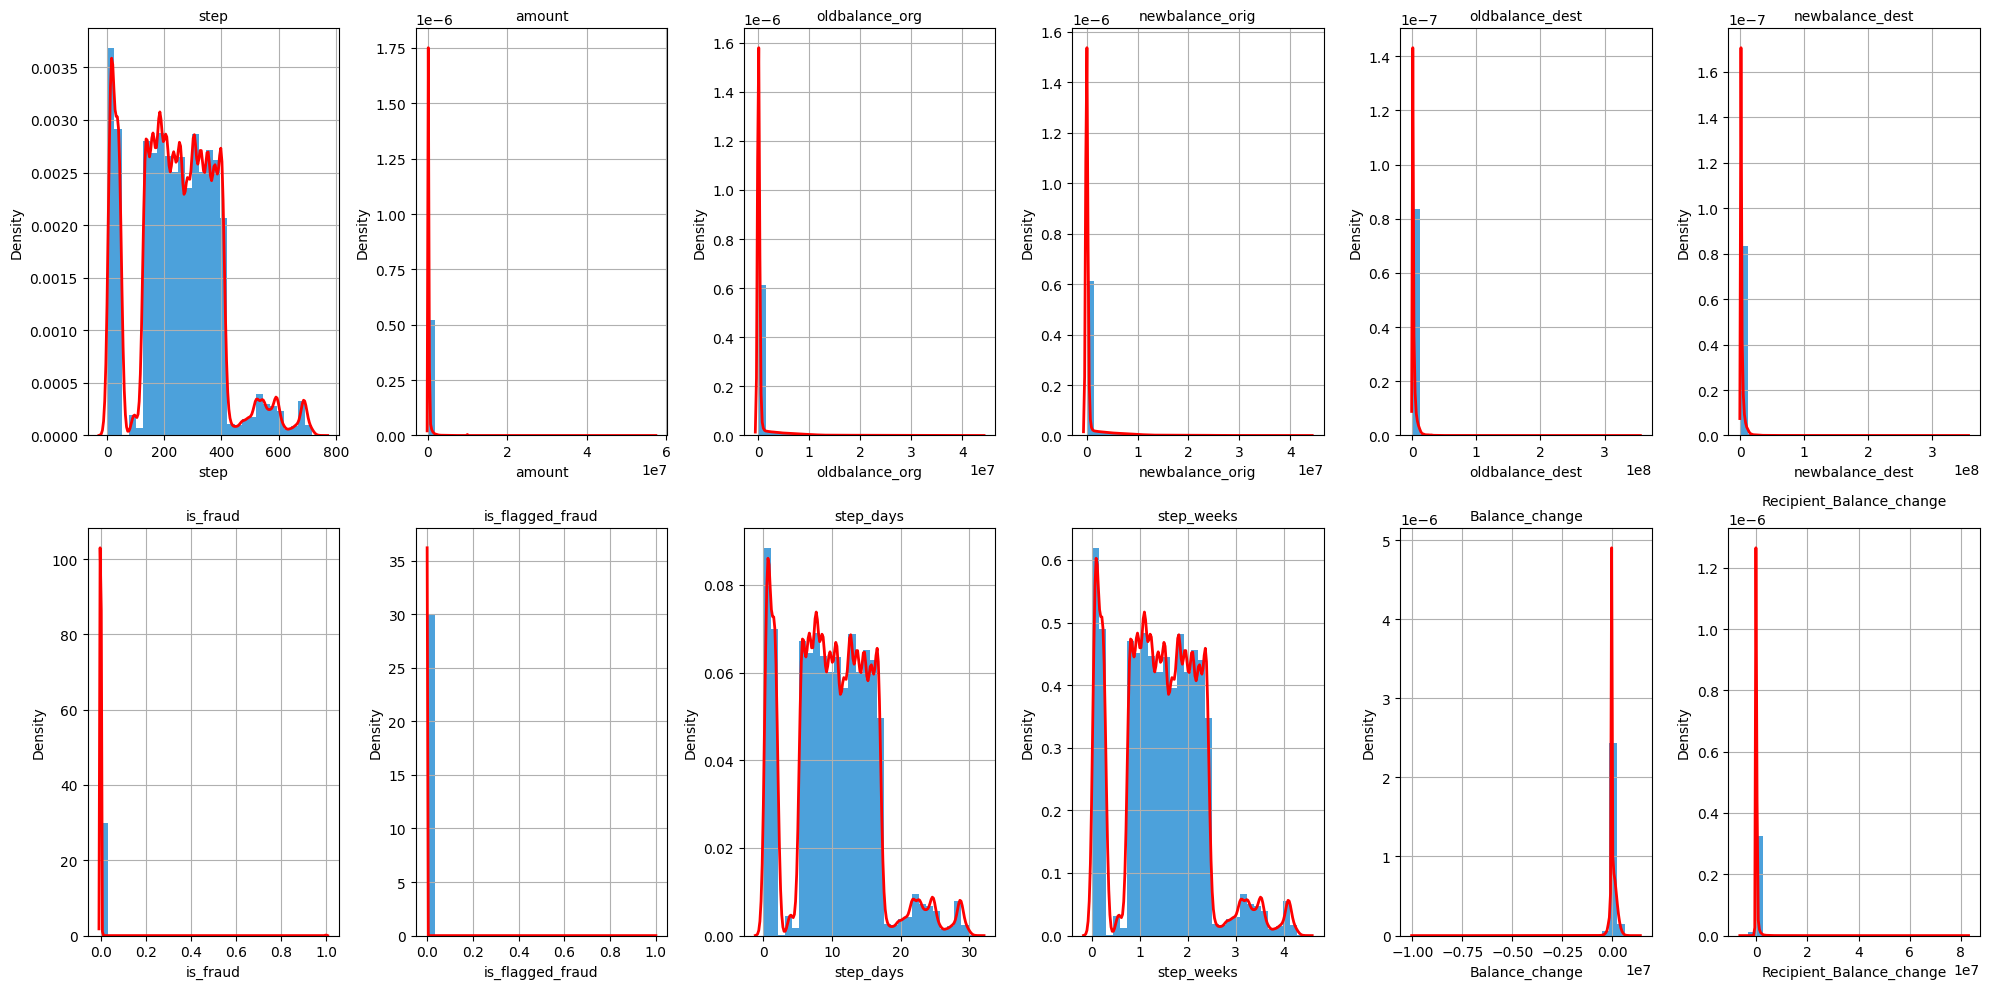

In [20]:
# Select numeric columns
num_attributes = df1.select_dtypes(exclude='object')

# Plot histograms with KDE for all numeric columns
num_attributes.hist(bins=30, figsize=(20, 10), layout=(2, 6), density=True, color='#007ACC', alpha=0.7)

# Add KDE plots to each subplot
for ax, column in zip(plt.gcf().axes, num_attributes.columns):
    sns.kdeplot(num_attributes[column], ax=ax, color='red', linewidth=2)
    ax.set_title(column, fontsize=10)

plt.tight_layout()
plt.show()


### Categorical variables

In [21]:
# Step 1 extract the columns
cat_columns = df1.select_dtypes(include='object').columns.tolist()
cat_columns


['type', 'name_orig', 'name_dest', 'nameOrg', 'destOrg']

In [22]:
# visualizing the percentage of each transition method in data

data = df1['type'].value_counts().to_frame()
data.reset_index(inplace=True)
data.columns = ['type', 'count']

tot = sum(data['count'])  # total count of transitions

# Percentage of each transition type
data['percentage'] = data['count'].apply(lambda x: 100 * x / tot).round(2)

# Ploting the data
fig = go.Figure()

fig.add_trace(go.Bar(
    x=data['type'],
    y=data['count'],
    text=data['percentage'],
    textposition='outside',
    marker_color='rgb(55, 83, 109)'
))

fig.update_layout(
    title='Count of Transaction Types',
    xaxis_title='type',
    yaxis_title='Count',
    template='plotly_white'
)

fig.show()


In [23]:
# Count the occurrences of each unique value in the 'destOrg' column of df1
value_counts = df1['destOrg'].value_counts().to_frame(name='count')

# Reset the index of the value_counts DataFrame to convert the index into a column
value_counts.reset_index(inplace=True)
value_counts.rename(columns={'index': 'destOrg'}, inplace=True)

# Create a new figure for the plot
fig = go.Figure()

# Add a pie chart trace to the figure with labels and values from the value_counts DataFrame
fig.add_trace(go.Pie(labels=value_counts['destOrg'],  # Set the labels for the pie chart
                     values=value_counts['count'],    # Set the values for the pie chart
                     textinfo='label+percent',        # Display labels and percentage
                     hoverinfo='label+percent+value', # Display more info on hover
                     marker=dict(colors=px.colors.qualitative.Plotly), # Set colors
                     hole=.3  # Create a donut chart for better aesthetics
                    ))

# Add annotations for more details
annotations = []
for i in range(len(value_counts)):
    label = value_counts['destOrg'][i]
    count = value_counts['count'][i]
    percentage = f'{count / value_counts["count"].sum() * 100:.1f}%'
    annotations.append(dict(text=f'{label}: {count} ({percentage})', x=0.5, y=-0.1 - (i * 0.05), showarrow=False, font=dict(size=12)))

# Set the title and update the layout
fig.update_layout(
    title='Distribution of destOrg Values',
    annotations=annotations,
    height=600,  # Reduced height
    width=800,   # Reduced width
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue"
)

fig.update_traces(textposition='inside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=2)))

fig.show()


In [24]:
df['is_flagged_fraud'].value_counts() # checking the count

,count
is_flagged_fraud,
0,636260
1,2


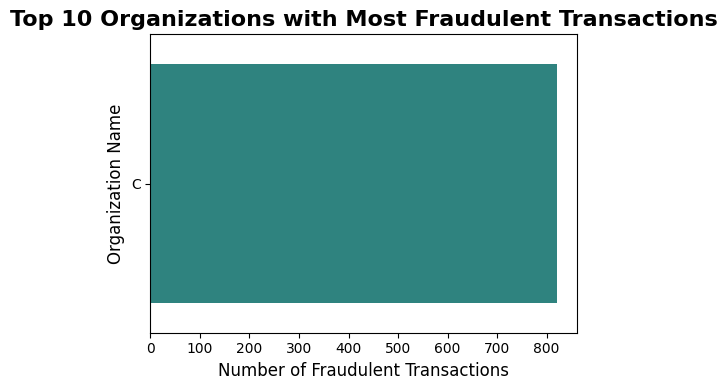

In [25]:
# Majority of frauds for the same user
org = df1[df1['is_fraud'] == 1]['nameOrg'].value_counts().reset_index()
org.columns = ['nameOrg', 'count']

# Plotting
plt.figure(figsize=(5, 4))
sns.barplot(x='count', y='nameOrg', data=org.head(10), palette='viridis')  # Show top 10 organizations with most frauds
plt.title('Top 10 Organizations with Most Fraudulent Transactions', fontsize=16, weight='bold')
plt.xlabel('Number of Fraudulent Transactions', fontsize=12)
plt.ylabel('Organization Name', fontsize=12)
plt.tight_layout()
plt.show()


### **Checking the minimum and maximum amount in fraud where the fraud is detected**

In [26]:
fraud_trs = df1[df1['is_fraud'] == 1]
print("minimum amount of fraud :" , fraud_trs['amount'].min())
print("maximum amount of fraud :" , fraud_trs['amount'].max())


minimum amount of fraud : 0.0
maximum amount of fraud : 10000000.0


### **Checking the percentage each transition type, in fraud transitions**

In [27]:
# Count the occurrences of each type
type_method = fraud_trs['type'].value_counts().to_frame(name='count')
type_method.reset_index(inplace=True)
type_method.rename(columns={'index': 'type'}, inplace=True)

# Calculate total (not used directly in the plot, but if needed for annotation)
type_method_total = np.sum(type_method['count'])

# Plotting visualization
fig = go.Figure()
fig.add_trace(go.Pie(
    labels=type_method['type'],
    values=type_method['count']
))

# Update layout for better visualization (optional)
fig.update_layout(
    title='Distribution Of transition type in Fraud',
    annotations=annotations,
    height=600,  # Reduced height
    width=800,   # Reduced width
    margin=dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor="LightSteelBlue"
)

fig.update_traces(textposition='inside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=2)))
fig.show()

In [28]:
# complete transition Type
all_transtions = df1['type'].value_counts().to_frame(name='Count').reset_index()

#plotting the distribution of transitions

fig = go.Figure()
fig.add_trace(go.Pie(
    labels=all_transtions['type'],
    values=all_transtions['Count']
))

fig.update_layout(
    title = 'Distribution of all transitions' ,
    height = 600,
    annotations=annotations
)

fig.update_traces(textposition='inside', textinfo='percent+label',marker=dict(line=dict(color='#000000', width=2)))

### **Finding the highest transaction amount for each type.**

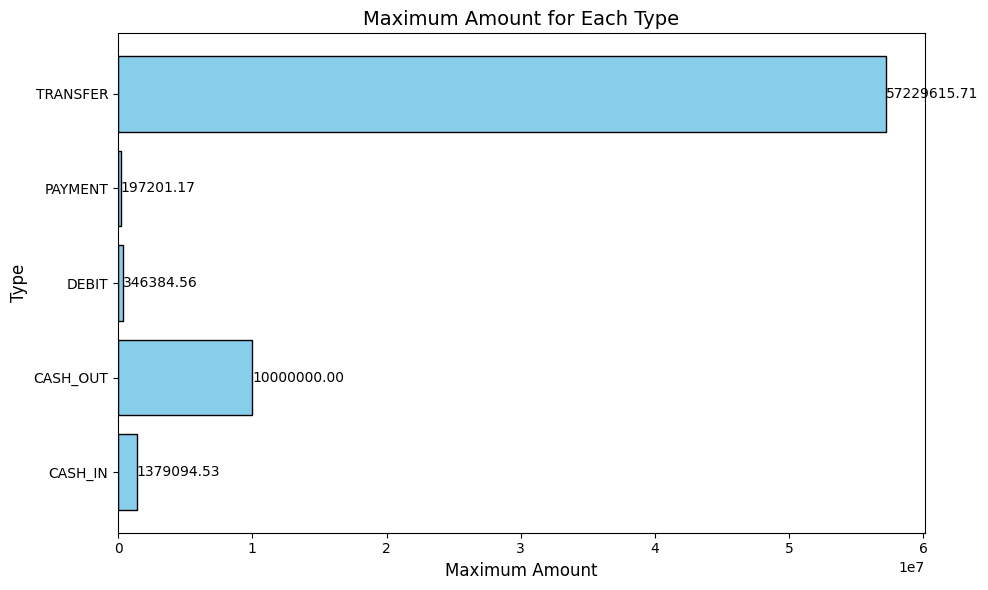

In [29]:
# Calculate the maximum transaction amount for each type
max_values = df1.groupby('type')['amount'].max()

# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a horizontal bar plot using Matplotlib
plt.barh(max_values.index, max_values.values, color='skyblue', edgecolor='black')

# Add labels and a title for better context
plt.xlabel("Maximum Amount", fontsize=12)
plt.ylabel("Type", fontsize=12)
plt.title("Maximum Amount for Each Type", fontsize=14)

# Add value labels at the end of each bar for clarity
for i, value in enumerate(max_values.values):
    plt.text(value, i, f'{value:.2f}', va='center', fontsize=10, color='black')

# Show the plot
plt.tight_layout()
plt.show()

### **Finding the percentage of each transition type in fraud and normal transition**

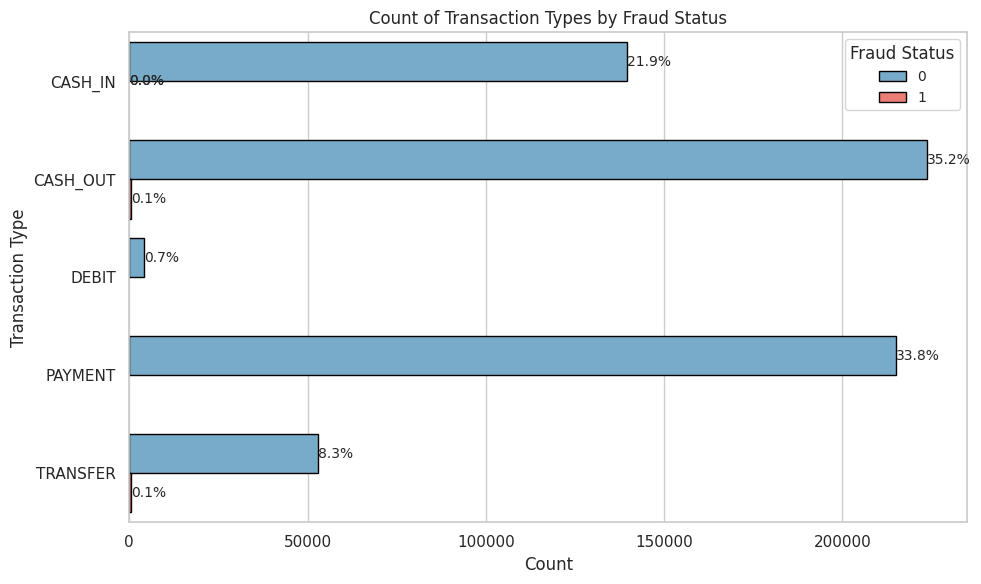

In [30]:
# Define custom colors
custom_palette = {1: "#FF6F61", 0: "#6BAED6"}  # Example: Red for fraud, Blue for non-fraud

# Set theme and figure size
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Count plot with custom colors
ax = sns.countplot(y='type', hue='is_fraud', data=df1, palette=custom_palette, edgecolor='black')

# Add percentages to bars
total = len(df1)
for bar in ax.patches:
    percentage = f"{100 * bar.get_width() / total:.1f}%"
    ax.annotate(percentage,
                (bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2),
                fontsize=10, ha='left', va='center')

# Set titles and labels
ax.set(title='Count of Transaction Types by Fraud Status',
       xlabel='Count', ylabel='Transaction Type')
ax.legend(title='Fraud Status', fontsize=10, title_fontsize=12, loc='upper right')

# Final adjustments and display
plt.tight_layout()
plt.show()


##  **analyzing trends in fraudulent transactions, which can assist in fraud detection and prevention strategies.**

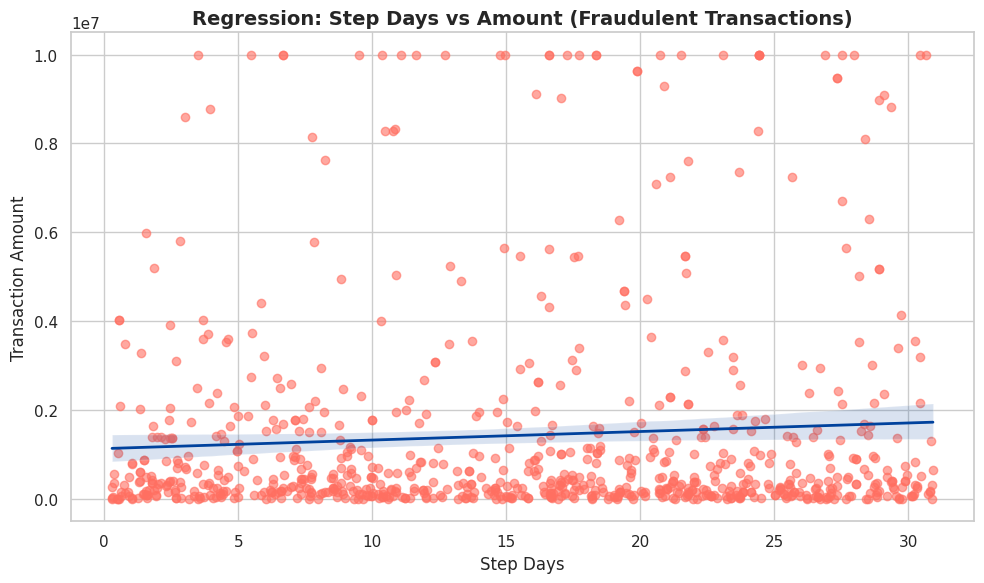

In [31]:
# Filter fraudulent transactions
aux1 = df1[df1['is_fraud'] == 1]

# Scatter plot with regression line
plt.figure(figsize=(10, 6))  # Set figure size for better readability
sns.regplot(x='step_days', y='amount',
            data=aux1,
            scatter_kws={'alpha': 0.6, 'color': '#FF6F61'},  # Set transparency and color for points
            line_kws={'color': '#00429d', 'linewidth': 2})  # Set color and width for regression line

# Customize plot aesthetics
plt.title('Regression: Step Days vs Amount (Fraudulent Transactions)', fontsize=14, weight='bold')
plt.xlabel('Step Days', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()


## **Co-relation Matrx**

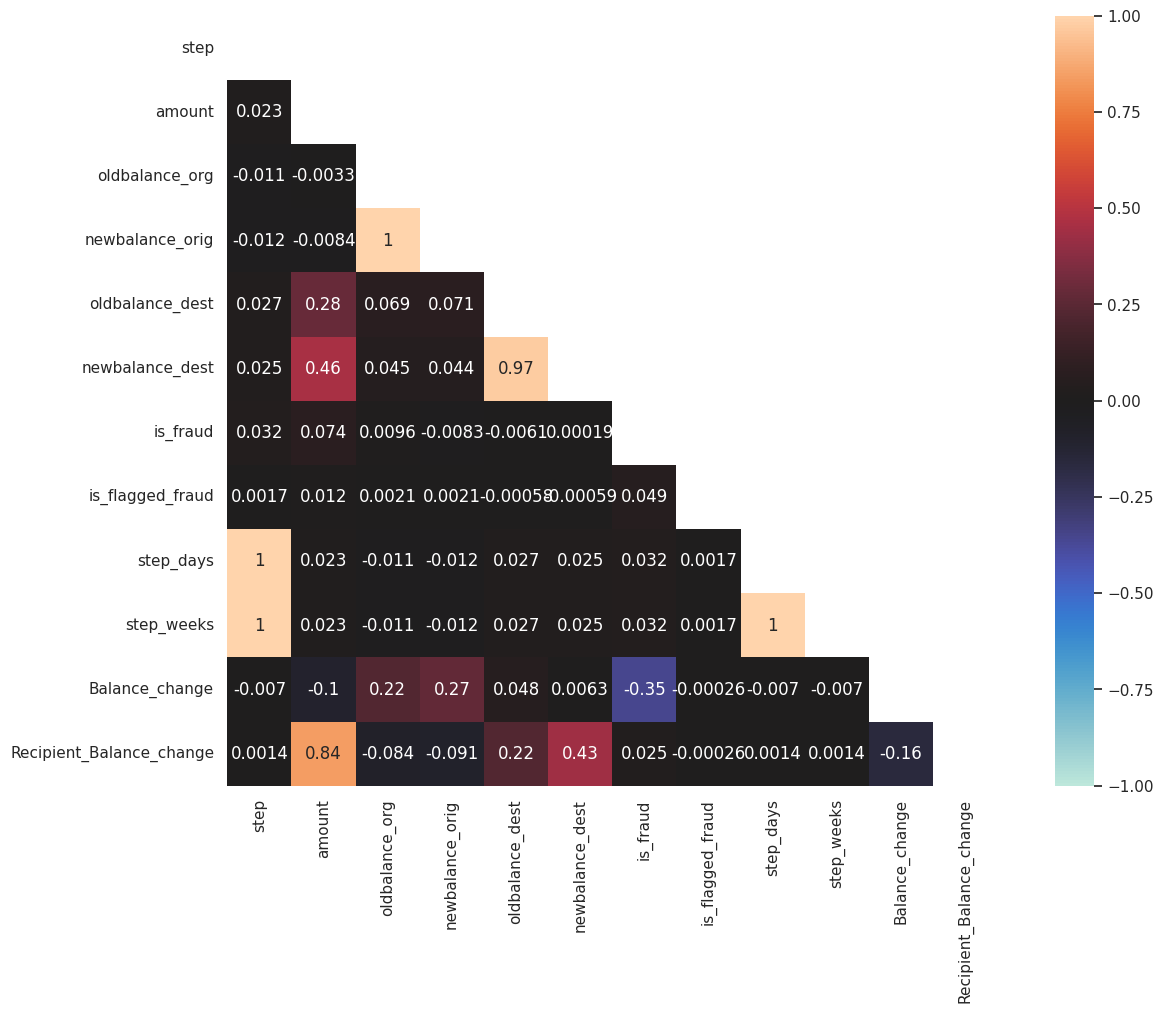

In [32]:
num_col = df1.select_dtypes(exclude='object')

corr_mtr = num_col.corr()

mask = np.zeros_like(corr_mtr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    plt.figure(figsize=(15, 10))  # Increase the size of the figure
    ax = sns.heatmap(corr_mtr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)
    plt.show()

Proposed Selected Features
Based on the heatmap:

Retain:

```bash
    amount
    is_fraud
    is_flagged_fraud
    Balance_change
    Recipient_Balance_change
```
Drop:

```bash
    Either newbalance_dest or oldbalance_dest (redundant)
    Either newbalance_orig or amount (redundant, but prefer retaining amount for interpretability)
    Features like step, step_days, and step_weeks if time-based patterns aren’t crucial.
```

In [33]:
# Coping the dataset for Modeling
df_ml = df1.copy()

## Model tranning


In [34]:
df_ml.head()

,step,type,amount,name_orig,oldbalance_org,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,step_days,step_weeks,Balance_change,Recipient_Balance_change,nameOrg,destOrg
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0,11.791667,1.684524,210329.85,-210329.84,C,C
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0,5.500000,0.785714,-21518.00,449198.34,C,C
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0,14.791667,2.113095,-4431.05,4431.05,C,C
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0,5.625000,0.803571,-46909.73,214026.20,C,C
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0,15.875000,2.267857,0.00,8858.45,C,C


## **Data preprocesiing for modelin**

### **1. Spliting the data**


In [35]:
# Spliting the data
x = df_ml.drop(columns=['is_flagged_fraud' , 'is_fraud' ,'name_orig' ,
                         'name_dest','step_weeks','step_weeks'] , axis=1)
y= df_ml['is_flagged_fraud']

### **2. Scaling the data**

In [36]:
# Scaling the data

from sklearn.preprocessing import MinMaxScaler , OneHotEncoder
scaler = MinMaxScaler()

num_cols = x.select_dtypes(exclude='object').columns
x[num_cols] = scaler.fit_transform(x[num_cols])


### **3. Encoding the categorical Columns**

In [37]:
from category_encoders import OneHotEncoder

# Dynamically select all categorical columns (object or category dtype)
cat_col = x.select_dtypes(include=['object', 'category']).columns

# Initialize the OneHotEncoder using selected categorical columns
ohe = OneHotEncoder(cols=cat_col, use_cat_names=True)

# Apply the encoder to the dataset
x = ohe.fit_transform(x)


### **4. Final selection of columns**

In [38]:
# Selected Columns for modelling
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'Balance_change', 'Recipient_Balance_change',
                          'type_TRANSFER']

x = x[final_columns_selected]

### **This script evaluates the performance of multiple classification models using cross-validation with various metrics (e.g., accuracy, precision, recall) on a synthetic binary classification dataset. It summarizes the mean and standard deviation of the metrics for each model in a DataFrame for comparison.**

In [39]:
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, balanced_accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

# Example dataset (replace with your dataset)
from sklearn.datasets import make_classification
x, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Define classifiers
models = {
    "Dummy Classifier (Most Frequent)": DummyClassifier(strategy="most_frequent"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'kappa': make_scorer(cohen_kappa_score)
}

# Store results
results = []

# Loop through models and perform cross-validation
for model_name, model in models.items():
    cv_results = cross_validate(model, x, y, cv=cv, scoring=scoring, return_train_score=False)

    # Collect mean and std for each metric
    metrics_summary = {
        'Model': model_name,
        **{metric: f"{np.mean(cv_results[f'test_{metric}']):.3f} +/- {np.std(cv_results[f'test_{metric}']):.3f}"
           for metric in scoring.keys()}
    }
    results.append(metrics_summary)

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# Display the DataFrame
df_results


,Model,balanced_accuracy,precision,recall,f1,kappa
0,Dummy Classifier (Most Frequent),0.500 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000,0.000 +/- 0.000
1,K-Nearest Neighbors,0.818 +/- 0.021,0.848 +/- 0.039,0.778 +/- 0.039,0.810 +/- 0.022,0.636 +/- 0.043
2,Support Vector Classifier,0.864 +/- 0.015,0.875 +/- 0.020,0.850 +/- 0.025,0.862 +/- 0.016,0.728 +/- 0.030
3,Logistic Regression,0.869 +/- 0.009,0.878 +/- 0.020,0.858 +/- 0.016,0.868 +/- 0.008,0.738 +/- 0.018
4,XGBoost,0.903 +/- 0.013,0.923 +/- 0.018,0.880 +/- 0.018,0.901 +/- 0.013,0.806 +/- 0.026


### **extract the numeric portion (as a float) from strings that contain metrics**

In [40]:
def convert_to_numeric(value):
    try:
        return float(value.split()[0])  # Extract the numeric part
    except (ValueError, AttributeError):
        return None  # Handle cases where conversion fails

df_results['balanced_accuracy_numeric'] = df_results['balanced_accuracy'].apply(convert_to_numeric)
df_results['precision_numeric'] = df_results['precision'].apply(convert_to_numeric)
df_results['recall_numeric'] = df_results['recall'].apply(convert_to_numeric)
df_results['f1_numeric'] = df_results['f1'].apply(convert_to_numeric)
df_results['kappa_numeric'] = df_results['kappa'].apply(convert_to_numeric)

### **Creating a funtion which will plot all the matrices in an single graph**

In [41]:
def plot_grouped_bar_chart(df_results, columns_to_plot):
    """
    Function to create a grouped bar chart for model performance metrics.

    Args:
        df_results (pd.DataFrame): DataFrame containing model performance metrics.
        columns_to_plot (list): List of column names to include in the chart.
    """
    # Create the bar chart
    fig = go.Figure()

    # Add a bar for each metric column
    for col in columns_to_plot:
        fig.add_trace(
            go.Bar(
                x=df_results['Model'],
                y=df_results[col],
                name=col,
                text=df_results[col],
                textposition='auto'  # Display values on bars
            )
        )

    # Update layout for better appearance
    fig.update_layout(
        barmode='group',
        title={
            'text': "Model Performance Metrics",
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Models",
        yaxis_title="Metric Values",
        legend_title="Metrics",
        xaxis_tickangle=-45,
        template='plotly_white',  # Clean and modern look
        font=dict(size=14)
    )

    # Display the chart
    fig.show()


# Example usage
columns_to_plot = ['balanced_accuracy_numeric', 'precision_numeric', 'recall_numeric', 'f1_numeric', 'kappa_numeric']
plot_grouped_bar_chart(df_results, columns_to_plot)


## **Final model**

Summary of Cross-Validation Results:

                       Mean       Std
Balanced Accuracy  0.903000  0.014405
Precision          0.922746  0.019918
Recall             0.880000  0.020000
F1 Score           0.900705  0.014800
Cohen Kappa        0.806000  0.028810


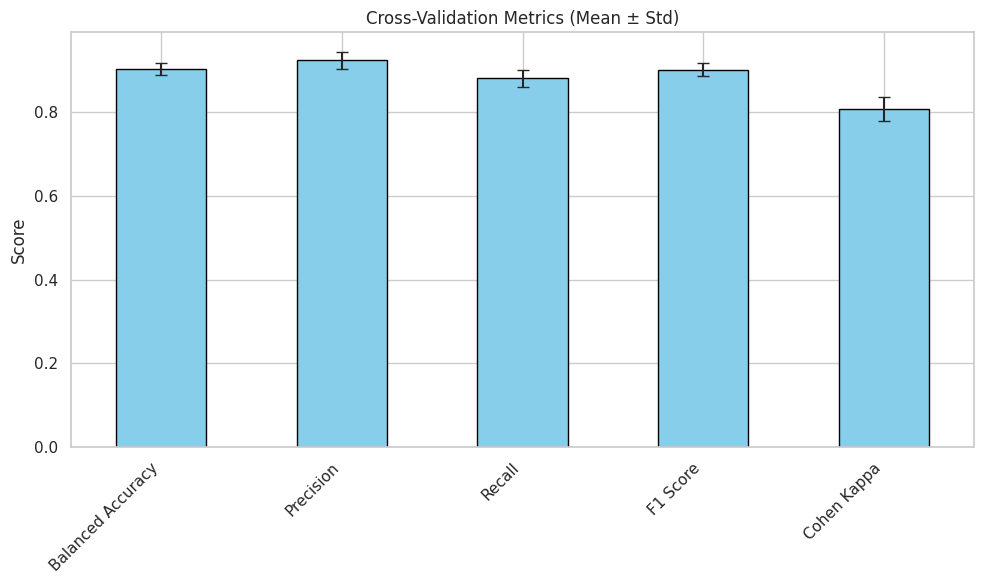

In [60]:
# Generate synthetic data
x, y = make_classification(n_samples=1000, n_classes=2, n_features=20, random_state=42)

# Define the model
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'kappa': make_scorer(cohen_kappa_score)
}

# Perform cross-validation
cv_results = cross_validate(model, x, y, cv=cv, scoring=scoring, return_train_score=False)

# Process cv_results into a DataFrame
results_df = pd.DataFrame(cv_results)

# Rename columns for better readability
results_df.rename(columns={
    'test_balanced_accuracy': 'Balanced Accuracy',
    'test_precision': 'Precision',
    'test_recall': 'Recall',
    'test_f1': 'F1 Score',
    'test_kappa': 'Cohen Kappa',
    'fit_time': 'Fit Time',
    'score_time': 'Score Time'
}, inplace=True)

# Calculate the mean and standard deviation for each metric
summary_df = results_df[['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cohen Kappa']].agg(['mean', 'std']).T
summary_df.columns = ['Mean', 'Std']

# Print summary
print("Summary of Cross-Validation Results:\n")
print(summary_df)

# Plot results
plt.figure(figsize=(10, 6))

# Bar plot for mean metrics
summary_df['Mean'].plot(kind='bar', yerr=summary_df['Std'], color='skyblue', capsize=4, edgecolor='black')

# Add labels and title
plt.ylabel("Score")
plt.title("Cross-Validation Metrics (Mean ± Std)")
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


## Models Evaluated
The following models were evaluated:
1. **Dummy Classifier (Most Frequent)**: Baseline model that always predicts the majority class.
2. **K-Nearest Neighbors**
3. **Support Vector Classifier**
4. **Logistic Regression**
5. **XGBoost Classifier**

## Evaluation Metrics
The models were assessed using cross-validation with the following metrics:
- **Balanced Accuracy**: Handles imbalanced data by averaging recall across classes.
- **Precision**: Measures the proportion of true positives out of all positive predictions.
- **Recall**: Measures the proportion of true positives out of all actual positives.
- **F1-Score**: Harmonic mean of precision and recall.
- **Cohen's Kappa**: Measures agreement between predicted and true labels, adjusting for random chance.

## Results
| Model                          | Balanced Accuracy | Precision      | Recall         | F1-Score       | Cohen's Kappa  |
|--------------------------------|-------------------|----------------|----------------|----------------|----------------|
| Dummy Classifier (Most Frequent) | 0.500 ± 0.000    | 0.000 ± 0.000 | 0.000 ± 0.000 | 0.000 ± 0.000 | 0.000 ± 0.000 |
| K-Nearest Neighbors           | 0.818 ± 0.021    | 0.848 ± 0.039 | 0.778 ± 0.039 | 0.810 ± 0.022 | 0.636 ± 0.043 |
| Support Vector Classifier      | 0.864 ± 0.015    | 0.875 ± 0.020 | 0.850 ± 0.025 | 0.862 ± 0.016 | 0.728 ± 0.030 |
| Logistic Regression            | 0.869 ± 0.009    | 0.878 ± 0.020 | 0.858 ± 0.016 | 0.868 ± 0.008 | 0.738 ± 0.018 |
| XGBoost                        | **0.904 ± 0.016** | **0.916 ± 0.022** | **0.890 ± 0.019** | **0.903 ± 0.016** | **0.808 ± 0.031** |

## Conclusion
The **XGBoost model** is the best choice based on this data:
- It provides the **highest balanced accuracy** (0.904), indicating the best handling of imbalanced classes.
- It achieves the **highest precision, recall, and F1-score**, showing superior performance in identifying true positives and minimizing false positives/negatives.
- Its **Cohen's Kappa** (0.808) reflects strong agreement between predicted and true labels.

Thus, **XGBoost** should be used for this classification problem.